In [1]:
# Parameters
data_url = "https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_tournamentselection_seed140_pop100_mut.01_snapshot_5000.csv.gz"


In [2]:
import endomill
from nbmetalog import nbmetalog as nbm


In [3]:
nbm.print_metadata()


context: ci
hostname: b734aff1db69
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 3
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 3e2ab1fe-49de-441e-889b-df4af676b98b
timestamp: 2022-03-07T17:49:40Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.3.1
endomill==0.1.3
nbmetalog==0.2.6
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.3.0
json==2.0.9
ipykernel==5.5.3


In [4]:
data_urls = [
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_lexicaseselection_seed110_pop165_mut.01_snapshot_500.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_randomselection_seed7_pop100_mut.01_snapshot_5000.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_sharingselection_seed10_pop100_mut.01_snapshot_5000.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_tournamentselection_seed140_pop100_mut.01_snapshot_5000.csv.gz',
]

endomill.instantiate_over(
    parameter_packs=[
        {'data_url': data_url}
        for data_url in data_urls
    ],
)


detected executing.endomill.ipynb file
skipping instantiate_over


In [5]:
#define papermil parameters
data_url: str


In [6]:
import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import itertools as it
from keyname import keyname as kn
from matplotlib import pyplot as plt
import numpy as np
from os.path import basename
import pandas as pd
import sys
from teeplot import teeplot as tp
from tqdm import tqdm


In [7]:
nbm.print_metadata()


context: ci
hostname: b734aff1db69
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 7
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 3e2ab1fe-49de-441e-889b-df4af676b98b
timestamp: 2022-03-07T17:49:41Z00:00


IPython==7.16.1
endomill==0.1.3
ipykernel==5.5.3
ipython_genutils==0.2.0
json==2.0.9
keyname==0.4.1
logging==0.5.1.2
nbmetalog==0.2.6
re==2.2.1
yaml==5.3.1
zmq==22.3.0
Bio==1.79
alifedata_phyloinformatics_convert==0.5.0
matplotlib==3.3.2
numpy==1.21.5
pandas==1.1.2
teeplot==0.2.0


In [8]:
df = pd.read_csv(
    f'{data_url}?raw=true',
    compression='gzip',
)

nbm.print_dataframe_synopsis(df)

data_filename = basename(data_url)

print(data_filename)


digest: c2277468354f4f530cf48ae376f6e5e662e90fde759081d31c30bd6666840028
manifest:
  Column Configuration: '                              18#        ex., actual_bits=56+actual_strata=7+bits_error=-8+differentia=8+policy=TaperedDepthProportionalResolution+resolution=3+target_bits=64'
  Differentia Bit Width: '                             3#         ex., 8'
  Generation Of MRCA Lower Bound (inclusive): '        9#,360na   ex., 0.0'
  Generation Of MRCA Upper Bound (exclusive): '        16#,360na  ex., 1024.0'
  Generation of Taxon Compared From: '                 2#         ex., 5001'
  Generation of Taxon Compared To: '                   2#         ex., 5001'
  MRCA Bound Confidence: '                             3#         ex., 0.99609375'
  Rank of Earliest Detectable Mrca With: '             6#         ex., 0'
  Stratigraphic Column Actual Num Retained Strata: '   11#        ex., 7'
  Stratigraphic Column Expected Retained Bits: '       12#        ex., 56'
  Stratigraphic Column Expe

In [9]:
endomill.add_instance_outpath(
    f'a=phylogeny_reconstruction+source={kn.unpack(data_filename)["source"]}.endomill.ipynb'
)


In [10]:
df['Treatment'] = df.apply(
    lambda row: kn.pack({
        'target': row['Stratigraphic Column Target Retained Bits'],
        'differentia': row['Differentia Bit Width'],
        'policy': row['Stratum Retention Policy'],
    }),
    axis=1,
)


In [11]:
max_gen = df['Generation of Taxon Compared From'].max()


In [12]:
def create_distance_matrix(df):
    assert len(df['Treatment'].unique() == 1)

    counter = it.count()
    taxon_to_index = {
        taxon : next(counter)
        for taxon in df['Taxon Compared From'].unique()
    }
    label_list = sorted(
        [*df['Taxon Compared From'].unique()],
        key=lambda x: taxon_to_index[x],
    )
    assert len(label_list) == len(taxon_to_index)
    distance_dict = {
        (taxon_to_index[row['Taxon Compared From']], taxon_to_index[row['Taxon Compared To']]):
            row['Generation of Taxon Compared From']
            - row['Generation Of MRCA Lower Bound (inclusive)']/2
            - row['Generation Of MRCA Upper Bound (exclusive)']/2
        for __, row in df.iterrows()
    }

    distance_matrix = np.array([
        [
            float(distance_dict[(i, j)] + distance_dict[(j, i)])
            if i != j
            else 0.0
            for j in range(len(taxon_to_index))
        ]
        for i in range(len(taxon_to_index))
    ])

    return distance_matrix, label_list


In [13]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0]
        for row_idx, row in enumerate(matrix.tolist())
    ]


In [14]:
mrca_dict = {
    (row['Taxon Compared From'], row['Taxon Compared To']):
        row['Generation Of MRCA Lower Bound (inclusive)']/2
        + row['Generation Of MRCA Upper Bound (exclusive)']/2
    for __, row in df.iterrows()
}
for __, row in df.iterrows():
    mrca_dict[(row['Taxon Compared From'], row['Taxon Compared From'])] \
        = row['Generation of Taxon Compared From']

def construct_tree(df, algorithm):
    assert len(df['Treatment'].unique() == 1)
    distance_matrix, label_list = create_distance_matrix(df)
    np.nan_to_num(distance_matrix, nan=max_gen+1, copy=False)
    dm = DistanceMatrix([*map(str, label_list)], to_tril(distance_matrix))
    tree = getattr(DistanceTreeConstructor(), algorithm)(dm)

    # fixup orign times
    for leaf1, leaf2 in it.product(tree.get_terminals(), tree.get_terminals()):
        mrca_node = tree.common_ancestor(leaf1, leaf2)
        calculated_mrca_time = mrca_dict[(int(leaf1.name), int(leaf2.name))]
        mrca_node.origin_time = calculated_mrca_time

    # fixup branch lengths
    tree.root.edge_length = tree.root.origin_time
    for node in tree.find_clades():
        for child in node.clades:
            child.edge_length = child.origin_time - node.origin_time

    # reroot tree
    new_root = min(tree.find_clades(), key=lambda node: node.origin_time)
    tree = Phylo.BaseTree.Tree(root=new_root)

    return tree


In [15]:
trees = {
    (treatment, algorithm): construct_tree(group, algorithm)
    for treatment, group in tqdm(df.groupby('Treatment'))
    for algorithm in ('nj', 'upgma')
}


  0%|          | 0/18 [00:00<?, ?it/s]

 33%|███▎      | 6/18 [00:00<00:00, 55.98it/s]

 67%|██████▋   | 12/18 [00:00<00:00, 55.84it/s]

100%|██████████| 18/18 [00:00<00:00, 55.76it/s]

100%|██████████| 18/18 [00:00<00:00, 55.56it/s]

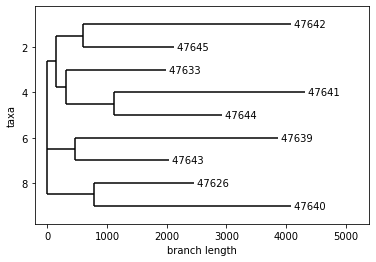

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

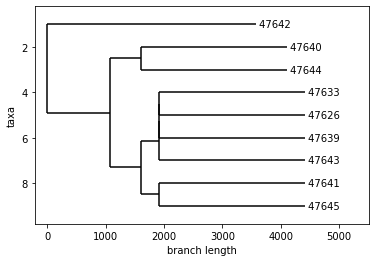

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

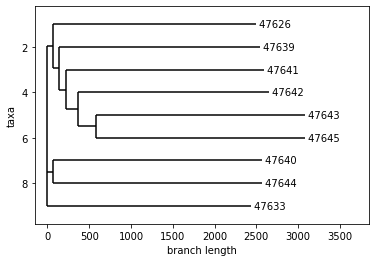

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

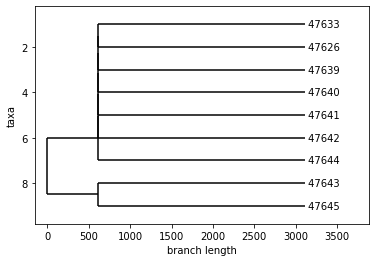

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

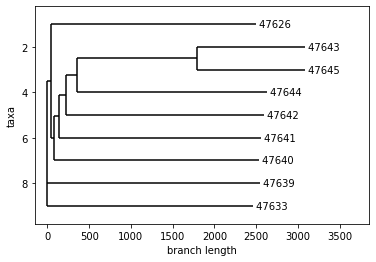

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

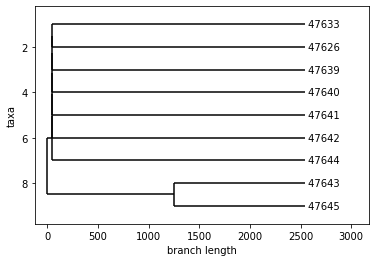

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

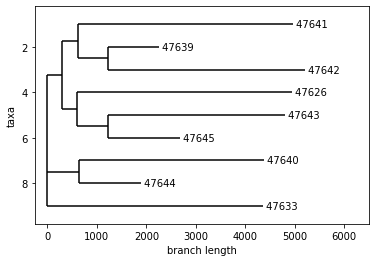

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

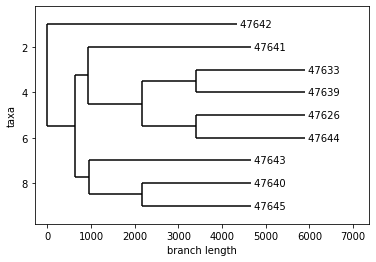

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

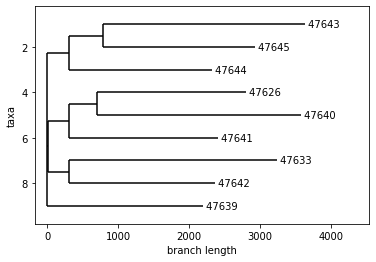

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

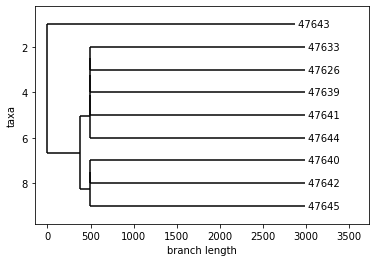

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

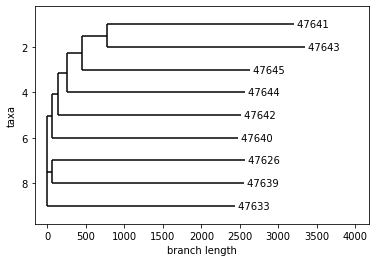

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

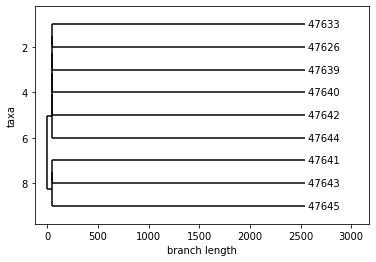

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

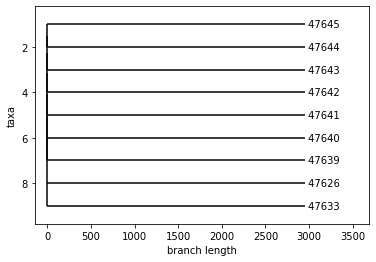

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

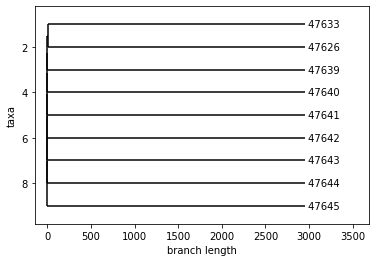

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

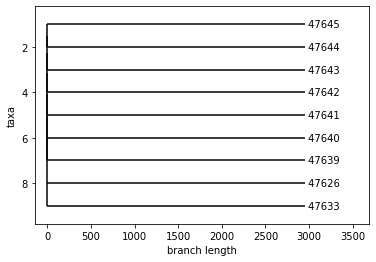

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

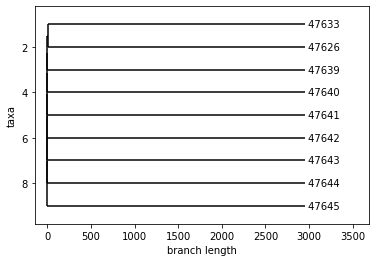

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

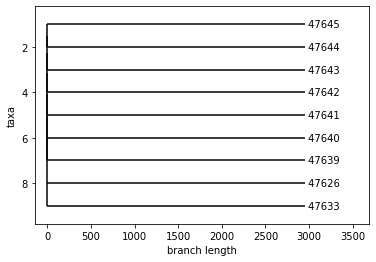

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

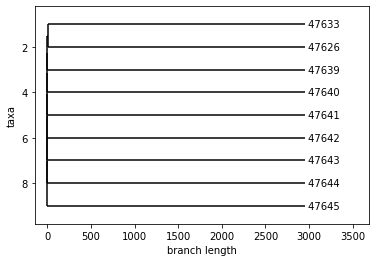

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

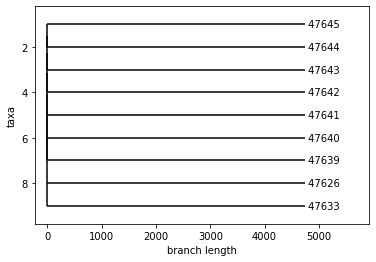

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

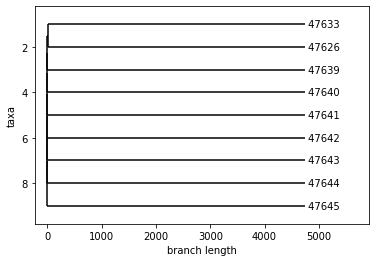

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

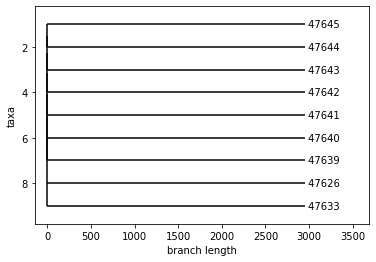

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

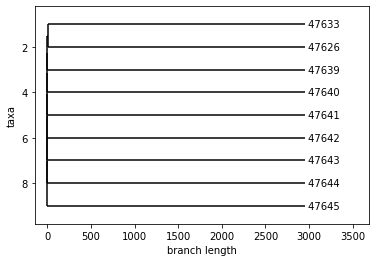

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

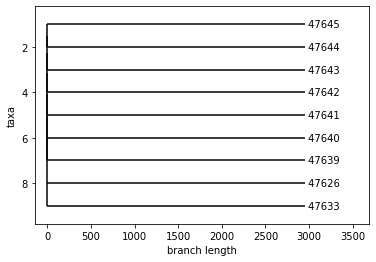

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

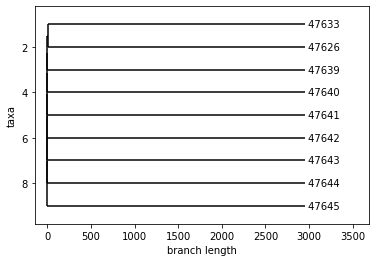

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

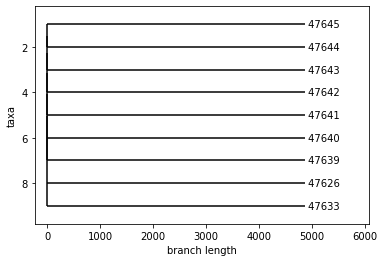

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

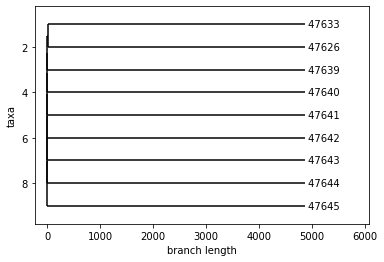

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

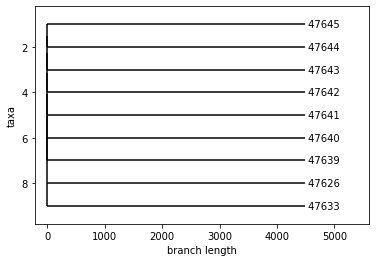

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

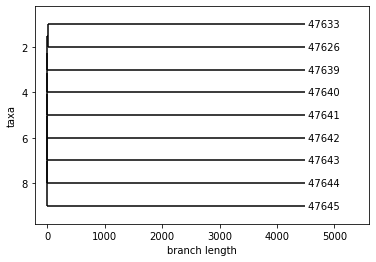

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

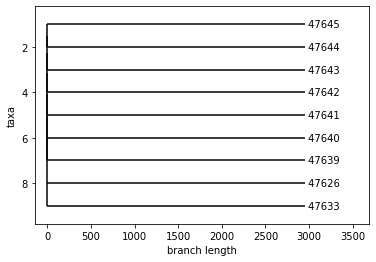

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

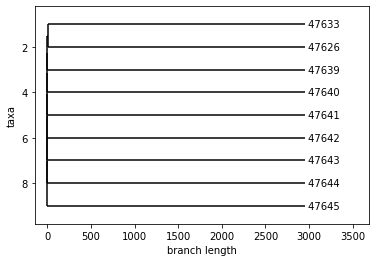

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

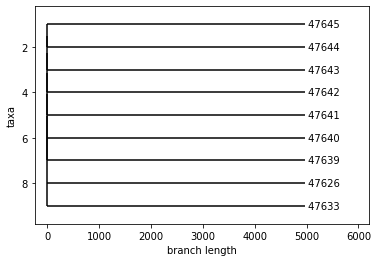

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

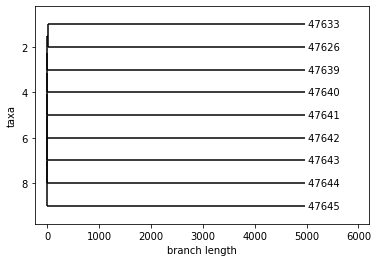

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

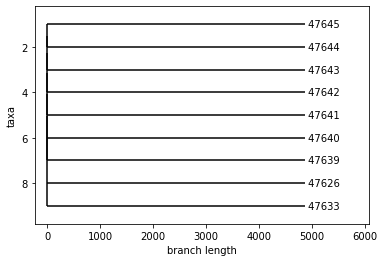

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

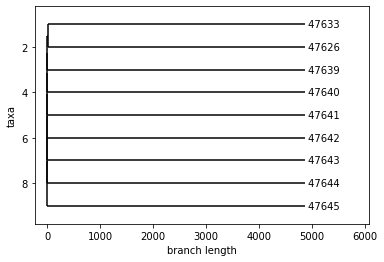

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

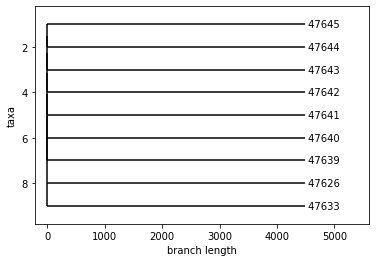

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

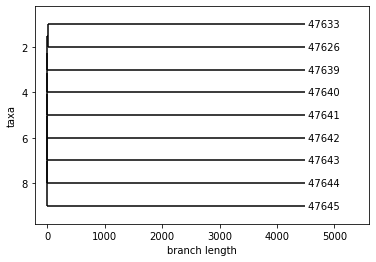

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

In [16]:
for (treatment, algorithm), tree in trees.items():
    tp.tee(
        Phylo.draw,
        tree,
        label_func=lambda node: None if 'Inner' in str(node) else str(node),
        teeplot_outattrs={
            'algorithm' : algorithm,
            'treatment' : kn.demote(treatment),
        },
    )
    plt.show()


In [17]:
alife_dataframes = {
    (treatment, algorithm): apc.biopython_tree_to_alife_dataframe(tree)
    for (treatment, algorithm), tree in trees.items()
}
for (treatment, algorithm), df in alife_dataframes.items():
    df['Treatment'] = treatment
    df['Algorithm'] = algorithm


In [18]:
res_df = pd.concat(alife_dataframes.values()).reset_index()


In [19]:
res_df


,index,id,ancestor_list,origin_time,branch_length,name,Treatment,Algorithm
0,0,0,[None],2048.0,0.000000,Inner7,differentia=1+policy=RecencyProportionalResolu...,nj
1,1,1,[0],2048.0,145.718750,Inner6,differentia=1+policy=RecencyProportionalResolu...,nj
2,2,2,[1],2048.0,457.281250,Inner3,differentia=1+policy=RecencyProportionalResolu...,nj
3,3,3,[2],5001.0,3475.400000,47642,differentia=1+policy=RecencyProportionalResolu...,nj
4,4,4,[2],5001.0,1526.600000,47645,differentia=1+policy=RecencyProportionalResolu...,nj
...,...,...,...,...,...,...,...,...
589,12,12,[4],5001.0,4488.875000,47641,differentia=8+policy=TaperedDepthProportionalR...,upgma
590,13,13,[3],5001.0,4488.937500,47642,differentia=8+policy=TaperedDepthProportionalR...,upgma
591,14,14,[2],5001.0,4488.968750,47643,differentia=8+policy=TaperedDepthProportionalR...,upgma
592,15,15,[1],5001.0,4488.984375,47644,differentia=8+policy=TaperedDepthProportionalR...,upgma


In [20]:
nbm.print_dataframe_synopsis(res_df)


digest: 9ebe3bc6a0339f3758cdf8b2fe7609a757378760962056d835f4e2e5a59f8a52
manifest:
  Algorithm: '     2#    ex., nj'
  Treatment: '     18#   ex., differentia=1+policy=RecencyProportionalResolution+target=1024'
  ancestor_list: ' 15#   ex., [None]'
  branch_length: ' 169#  ex., 0.0'
  id: '            17#   ex., 0'
  index: '         17#   ex., 0'
  name: '          17#   ex., Inner7'
  origin_time: '   3#    ex., 2048.0'
num cols: 8
num cols all na: 0
num cols any na: 0
num na: 0
num rows: 594
num rows all na: 0
num rows any na: 0
size: 195K



In [21]:
res_df.to_csv(
    f'a=reconstructed_phylogenies+source={kn.unpack(data_filename)["source"]}',
    compression='gzip',
)
